# ANALYSIS

In [ ]:
#uncomment this below code to install imblearn package
# !pip install imbalanced-learn

In [19]:
import pandas as pd
import numpy as np
import sklearn
import pyreadr

#statistics
from scipy.stats import chi2_contingency, ttest_ind

import cudf #gpu-powered DataFrame (Pandas alternative)

#imbalance handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, RepeatedEditedNearestNeighbours
from imblearn.pipeline import Pipeline

#preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler


#internal validation
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV, PredefinedSplit, train_test_split

#performance metrices
from sklearn.metrics import confusion_matrix, classification_report, f1_score, balanced_accuracy_score, matthews_corrcoef, auc, average_precision_score, roc_auc_score, balanced_accuracy_score, roc_curve, accuracy_score

#Models selection
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from cuml.svm import SVC #gpu-powered SVM



#save and load trained model
import pickle

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree

#Stats
import statsmodels.api as sm 

from collections import Counter
import os

In [20]:
# Data loader
# trainingData = pd.read_csv('../FinalData/trainingDataEncoded_.csv')
# validationData = pd.read_csv('../FinalData/validationDataEncoded_2vs1_16112023.csv')
# evaluationData = pd.read_csv('../FinalData/evaluationDataEncoded_2vs1_16112023.csv')
# evaluationDataWales = pd.read_csv('../FinalData/evaluationDataWalesEncoded_2vs1_16112023.csv')
# evaluationDataScotland = pd.read_csv('../FinalData/evaluationDataScotlandEncoded_2vs1_16112023.csv')


# trainingData = trainingData.rename({'outcome_3months': '3months', 'outcome_6months': '6months','outcome_12months': '12months','outcome_9months': '9months',}, axis=1)
# validationData = validationData.rename({'outcome_3months': '3months', 'outcome_6months': '6months','outcome_12months': '12months','outcome_9months': '9months',}, axis=1)
# evaluationData = evaluationData.rename({'outcome_3months': '3months', 'outcome_6months': '6months','outcome_12months': '12months','outcome_9months': '9months',}, axis=1)
# evaluationDataWales = evaluationDataWales.rename({'outcome_3months': '3months', 'outcome_6months': '6months','outcome_12months': '12months','outcome_9months': '9months',}, axis=1)
# evaluationDataScotland = evaluationDataScotland.rename({'outcome_3months': '3months', 'outcome_6months': '6months','outcome_12months': '12months','outcome_9months': '9months',}, axis=1)

trainingData, validationData, internalEvaluationData, evaluationData, evaluationDataWales, evaluationDataScotland = pickle.load(open('../FinalData/dataset_noOneHot_01122023.sav', 'rb'))

trainingData = trainingData.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)
validationData = validationData.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)
internalEvaluationData = internalEvaluationData.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)
evaluationData = evaluationData.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)
evaluationDataWales = evaluationDataWales.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)
evaluationDataScotland = evaluationDataScotland.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)

EnglandData = pd.concat([trainingData, validationData]).reset_index(drop=True)

In [21]:
target_outcomes = ['12months'] 
for target_outcome in target_outcomes:
    print('#######################################################')
    print(target_outcome)
    print(trainingData[target_outcome].value_counts(normalize=True))
    print(validationData[target_outcome].value_counts(normalize=True))
    print(evaluationData[target_outcome].value_counts(normalize=True))
    print(evaluationDataWales[target_outcome].value_counts(normalize=True))
    print(evaluationDataScotland[target_outcome].value_counts(normalize=True))

#######################################################
12months
0    0.875911
1    0.124089
Name: 12months, dtype: float64
0    0.875916
1    0.124084
Name: 12months, dtype: float64
0    0.830827
1    0.169173
Name: 12months, dtype: float64
0    0.841329
1    0.158671
Name: 12months, dtype: float64
0    0.811984
1    0.188016
Name: 12months, dtype: float64


In [27]:
#Define feature candidates

features_columns = trainingData.columns.to_list()
exclude_columns = ['patid', 'practice_id', #identifier
                   'BMI', #use the categorical instead
                   'ethnicity', #use ethnic_group instead
                   'Spacer',  #all zero
                   
                   'outcome_3months', 'outcome_6months', 'outcome_9months', 'outcome_12months', 'outcome_15months', 'outcome_18months', 
                   'outcome_21months', 'outcome_24months', 'outcome_combined_6months', 'outcome_combined_9months', 'outcome_combined_12months', 
                   'outcome_combined_15months', 'outcome_combined_18months', 'outcome_combined_24months', '3months', '6months',  '24months', #outcomes variable
                   '9months', '3MonthsOutcome', '6MonthsOutcome', '9MonthsOutcome', '12MonthsOutcome',
                   
                   # '12months', #include this as the outcome
                   
                   'postcode_district', 'County', 'LocalAuthority', 'OutputAreaClassification', #location related variables, use IMD decile only
                   
                   'cat_age', 'cat_average_daily_dose_ICS', 'cat_prescribed_daily_dose_ICS', 'cat_ICS_medication_possesion_ratio', 'cat_numOCS', 'cat_numOCSEvents', 
                   'cat_numOCSwithLRTI', 'cat_numAcuteRespEvents', 'cat_numAntibioticsEvents', 'cat_numAntibioticswithLRTI', 'cat_numAsthmaAttacks', 'cat_numHospEvents', 
                   'cat_numPCS', 'cat_numPCSAsthma', #use continous vars instead
                   
                   'count_rhinitis', 'count_cardiovascular', 'count_heartfailure',
                   'count_psoriasis', 'count_anaphylaxis', 'count_diabetes', 'count_ihd',
                   'count_anxiety', 'count_eczema', 'count_nasalpolyps',
                   'count_paracetamol', 'count_nsaids', 'count_betablocker', #use binary ones
                   
                   'paracetamol', 'nsaids', 'betablocker', #no data in evaluation
                   
                   'numOCSEvents', #duplicate with numOCS
                   
                   'month_12', 'month_4', 'month_5', 'month_10', 'month_1', 'month_6', 'month_3', 
                   'month_11', 'month_8', 'month_9', 'month_7', 'month_2', #month of attacks
                   
                   'system_EMIS', 'system_SystemOne', 'system_Vision', #system in practice
                  ]
exclude_columns = exclude_columns + [x for x in features_columns if '_count' in x] #filter out commorbid count variables
features_columns = [x for x in features_columns if x not in exclude_columns]
print('Features size: ', len(features_columns))
print(features_columns)

Features size:  36
['sex', 'age', 'ethnic_group', 'smokingStatus', 'CharlsonScore', 'PEFStatus', 'EosinophilLevel', 'BTS_step', 'average_daily_dose_ICS', 'prescribed_daily_dose_ICS', 'ICS_medication_possesion_ratio', 'DeviceType', 'numOCS', 'PriorEducation', 'numPCS', 'numPCSAsthma', 'numAntibioticsEvents', 'numAntibioticswithLRTI', 'numOCSwithLRTI', 'numAsthmaAttacks', 'numAcuteRespEvents', 'numHospEvents', 'imd_decile', 'system', 'cat_BMI', 'rhinitis', 'cardiovascular', 'heartfailure', 'psoriasis', 'anaphylaxis', 'diabetes', 'ihd', 'anxiety', 'eczema', 'nasalpolyps', '12months']


# Risk Factors Analysis

## England

In [28]:
data = EnglandData[EnglandData.system == 'Vision'][features_columns]
result = []
excluded_vars = ['numAcuteRespEvents']
for col in features_columns:
    if col not in excluded_vars:
        if(len(data[col].unique())>1): #handling Singluar matrix problem
            print(col)
            log_reg = sm.Logit(data[['12months']], data[[col]]).fit()
            sign = ['significant' if log_reg.pvalues[0] <= 0.05 else 'not significant']
            result.append([col, log_reg.pvalues[0], np.exp(log_reg.params[0]).tolist()] + np.exp(log_reg.conf_int().values[0]).tolist() + sign)

result = pd.DataFrame(result, columns=['Var', 'PVal', 'OR', '2.5%', '97.5%', 'Significant?'])
result.index = result.Var


sex
Optimization terminated successfully.
         Current function value: 0.535258
         Iterations 6
age
Optimization terminated successfully.
         Current function value: 0.435500
         Iterations 6
ethnic_group


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:
plt.figure(figsize=(8, 10), dpi=150)
ci = [result.iloc[::-1]['OR'] - result.iloc[::-1]['2.5%'].values, result.iloc[::-1]['97.5%'].values - result.iloc[::-1]['OR']]
plt.errorbar(x=result.iloc[::-1]['OR'], y=result.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=3, linestyle='None', elinewidth=1,
            marker='o', markersize=5, mfc="black", mec="black",barsabove=True,)
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(direction='inout', axis='both', which='major', labelsize=6)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

## Wales

In [195]:
data = evaluationDataWales
result = []
excluded_vars = ['DeviceType_NEB']
for col in features_columns:
    if col not in excluded_vars:
        if(len(data[col].unique())>1): #handling Singluar matrix problem
            log_reg = sm.Logit(data[['12months']], data[[col]]).fit()
            sign = ['significant' if log_reg.pvalues[0] <= 0.05 else 'not significant']
            result.append([col, log_reg.pvalues[0], np.exp(log_reg.params[0]).tolist()] + np.exp(log_reg.conf_int().values[0]).tolist() + sign)

result = pd.DataFrame(result, columns=['Var', 'PVal', 'OR', '2.5%', '97.5%', 'Significant?'])
result.index = result.Var


Optimization terminated successfully.
         Current function value: 0.513142
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.554689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681642
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.589923
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.620564
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688612
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691836
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.665581
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684731
  

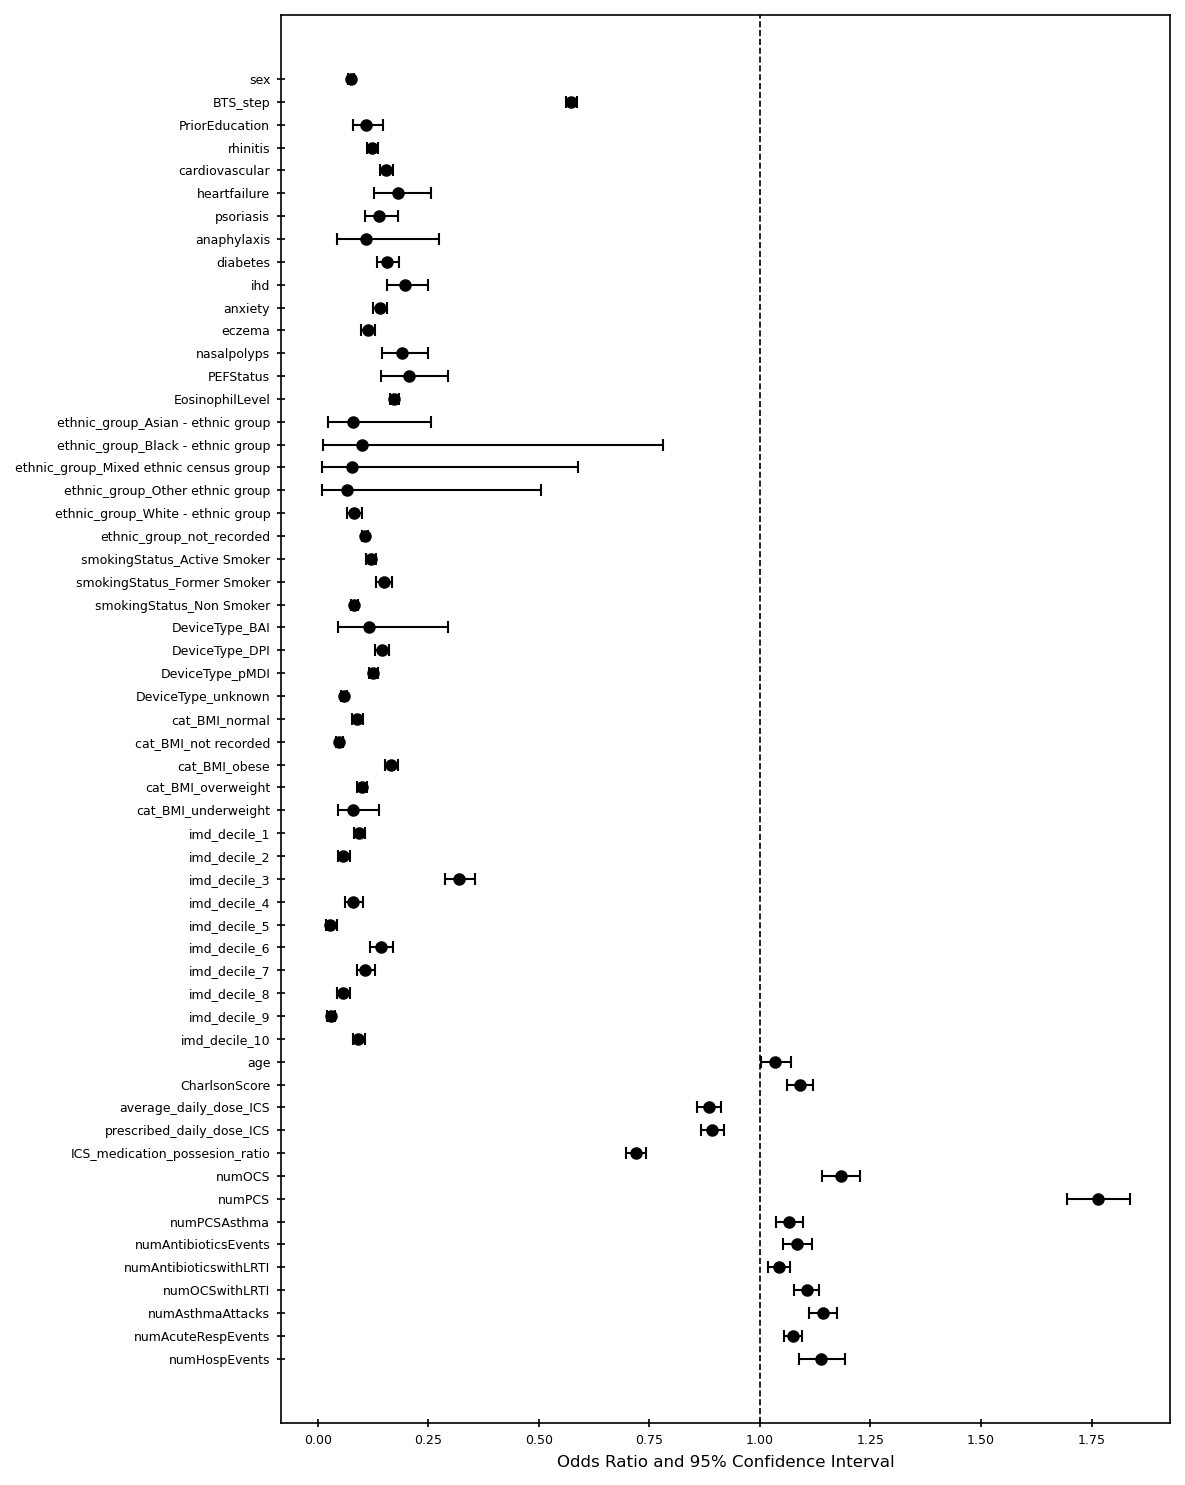

In [196]:
plt.figure(figsize=(8, 10), dpi=150)
ci = [result.iloc[::-1]['OR'] - result.iloc[::-1]['2.5%'].values, result.iloc[::-1]['97.5%'].values - result.iloc[::-1]['OR']]
plt.errorbar(x=result.iloc[::-1]['OR'], y=result.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=3, linestyle='None', elinewidth=1,
            marker='o', markersize=5, mfc="black", mec="black",barsabove=True,)
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(direction='inout', axis='both', which='major', labelsize=6)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

## Scotland

In [197]:
data = evaluationDataScotland
result = []
for col in features_columns:
    if(len(data[col].unique())>1): #handling Singluar matrix problem
        log_reg = sm.Logit(data[['12months']], data[[col]]).fit()
        sign = ['significant' if log_reg.pvalues[0] <= 0.05 else 'not significant']
        result.append([col, log_reg.pvalues[0], np.exp(log_reg.params[0]).tolist()] + np.exp(log_reg.conf_int().values[0]).tolist() + sign)

result = pd.DataFrame(result, columns=['Var', 'PVal', 'OR', '2.5%', '97.5%', 'Significant?'])
result.index = result.Var

Optimization terminated successfully.
         Current function value: 0.526171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.530308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.611176
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.592370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.678330
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689232
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680448
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690729
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.656826
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.669280
  

/opt/conda/envs/rapids/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_187/4132301545.py:7: RuntimeWarning: overflow encountered in exp
  result.append([col, log_reg.pvalues[0], np.exp(log_reg.params[0]).tolist()] + np.exp(log_reg.conf_int().values[0]).tolist() + sign)
/opt/conda/envs/rapids/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_187/4132301545.py:7: RuntimeWarning: overflow encountered in exp
  result.append([col, log_reg.pvalues[0], np.exp(log_reg.params[0]).tolist()] + np.exp(log_reg.conf_int().values[0]).tolist() + sign)
/opt/conda/envs/rapids/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: M

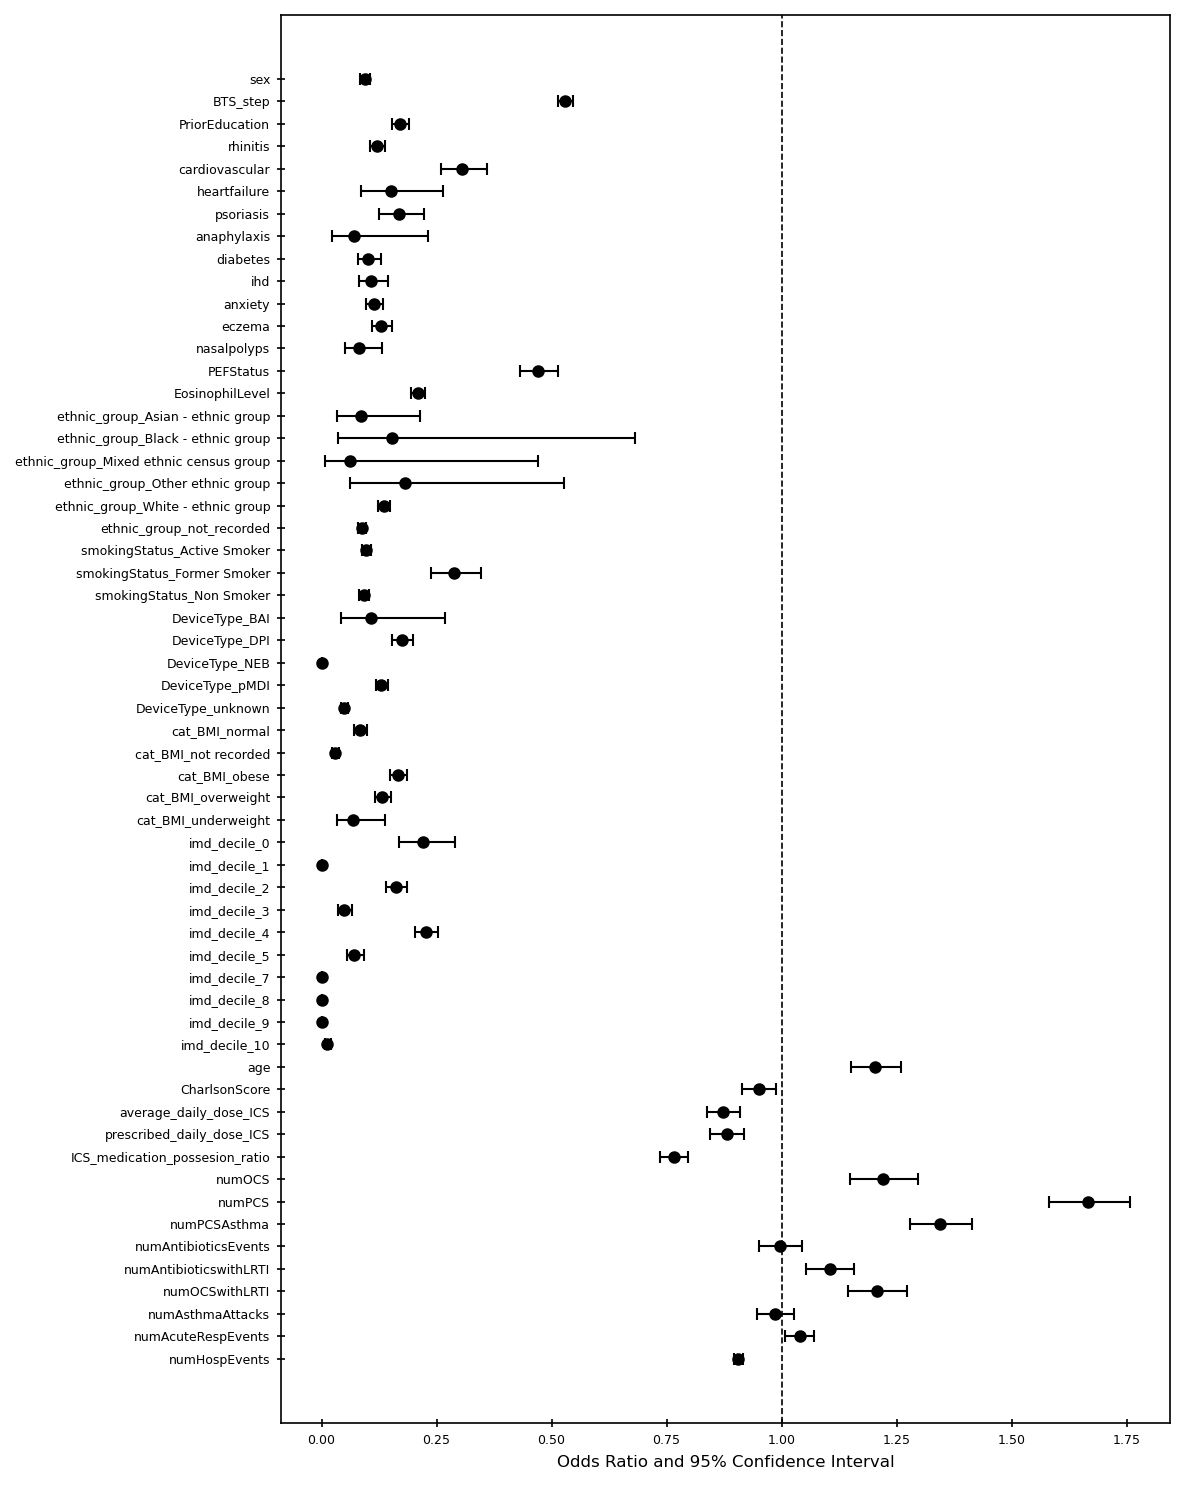

In [198]:
plt.figure(figsize=(8, 10), dpi=150)
ci = [result.iloc[::-1]['OR'] - result.iloc[::-1]['2.5%'].values, result.iloc[::-1]['97.5%'].values - result.iloc[::-1]['OR']]
plt.errorbar(x=result.iloc[::-1]['OR'], y=result.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=3, linestyle='None', elinewidth=1,
            marker='o', markersize=5, mfc="black", mec="black",barsabove=True,)
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(direction='inout', axis='both', which='major', labelsize=6)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

## All Data

In [199]:
data = pd.concat([EnglandData, evaluationData])
result = []
for col in features_columns:
    if(len(data[col].unique())>1): #handling Singluar matrix problem
        log_reg = sm.Logit(data[['12months']], data[[col]]).fit()
        sign = ['significant' if log_reg.pvalues[0] <= 0.05 else 'not significant']
        result.append([col, log_reg.pvalues[0], np.exp(log_reg.params[0]).tolist()] + np.exp(log_reg.conf_int().values[0]).tolist() + sign)

result = pd.DataFrame(result, columns=['Var', 'PVal', 'OR', '2.5%', '97.5%', 'Significant?'])
result.index = result.Var

Optimization terminated successfully.
         Current function value: 0.502060
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.577107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.655970
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.581937
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.534208
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.676818
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691534
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.642411
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633772
  

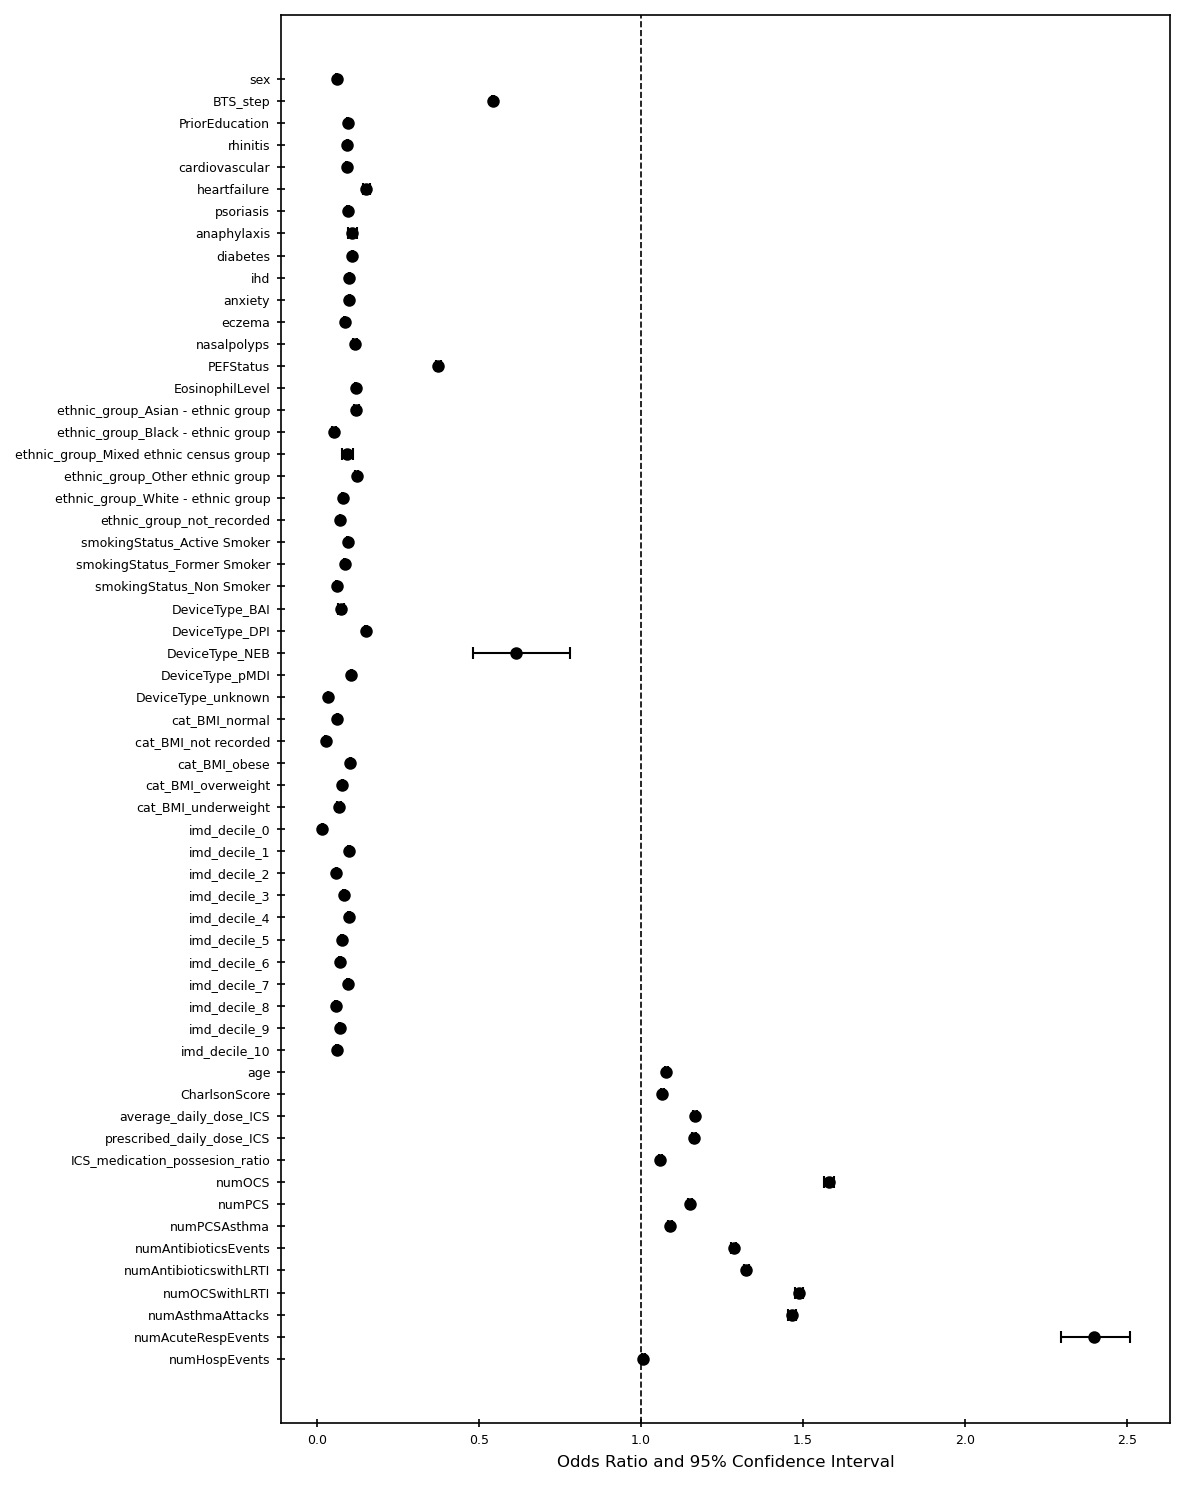

In [200]:
plt.figure(figsize=(8, 10), dpi=150)
ci = [result.iloc[::-1]['OR'] - result.iloc[::-1]['2.5%'].values, result.iloc[::-1]['97.5%'].values - result.iloc[::-1]['OR']]
plt.errorbar(x=result.iloc[::-1]['OR'], y=result.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=3, linestyle='None', elinewidth=1,
            marker='o', markersize=5, mfc="black", mec="black",barsabove=True,)
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(direction='inout', axis='both', which='major', labelsize=6)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

## All Evaluation Data

In [201]:
data = evaluationData
result = []
for col in features_columns:
    if(len(data[col].unique())>1): #handling Singluar matrix problem
        log_reg = sm.Logit(data[['12months']], data[[col]]).fit()
        sign = ['significant' if log_reg.pvalues[0] <= 0.05 else 'not significant']
        result.append([col, log_reg.pvalues[0], np.exp(log_reg.params[0]).tolist()] + np.exp(log_reg.conf_int().values[0]).tolist() + sign)

result = pd.DataFrame(result, columns=['Var', 'PVal', 'OR', '2.5%', '97.5%', 'Significant?'])
result.index = result.Var

Optimization terminated successfully.
         Current function value: 0.518084
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.546160
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.656062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.590819
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.642701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688845
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691438
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.662591
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679313
  

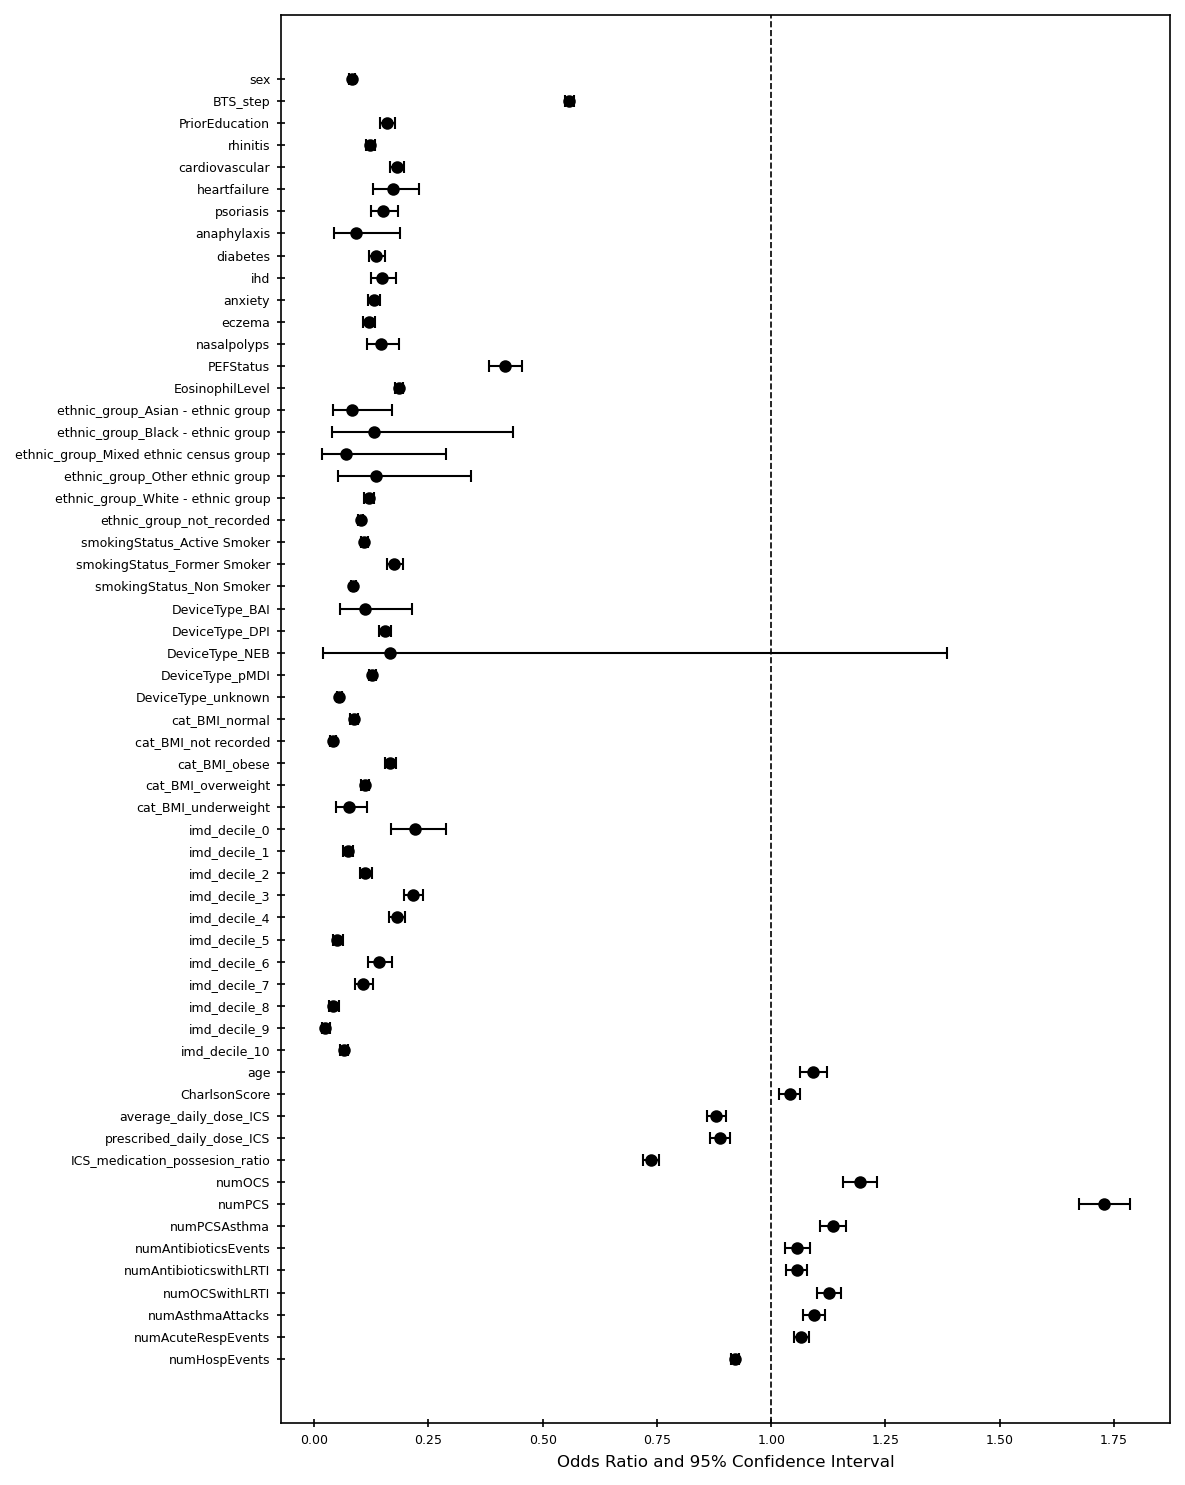

In [202]:
plt.figure(figsize=(8, 10), dpi=150)
ci = [result.iloc[::-1]['OR'] - result.iloc[::-1]['2.5%'].values, result.iloc[::-1]['97.5%'].values - result.iloc[::-1]['OR']]
plt.errorbar(x=result.iloc[::-1]['OR'], y=result.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=3, linestyle='None', elinewidth=1,
            marker='o', markersize=5, mfc="black", mec="black",barsabove=True,)
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(direction='inout', axis='both', which='major', labelsize=6)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()